Calculate time series and compare to HadSST4
============================================

The aim here is to compare the gridded anomalies to the unadjusted HadSST4 data. They should be approximately equal.

In [1]:
%matplotlib inline

import sys
sys.path.append('..')

import xarray as xr
import numpy as np
from pathlib import Path
from itertools import product
import os
import matplotlib.pyplot as plt

In [2]:
data_dir = Path(os.getenv("DATADIR"))

Area weights
============

Not every gridcell has the same surface area and not all grid cells are 100% ocean. In order to calculate the area averages correctly, we need to know the area of ocean in each 5x5 grid cell, so they can be weighted appropriately. To do this, I calcualte an approximate area fraction of ocean using the 1-degree lat-lon climatology and then multiply each of those fractions by the cosine of the latitude of grid box centre.

In [3]:
climatology = xr.open_dataset(data_dir / "SST_CCI_climatology" / "SST_1x1_daily.nc")
cos_lat_weights = np.cos(np.deg2rad(climatology.latitude))

# Use the SST values in the climatology as an ocean mask. Set area to 1 for gridcells with SSTs, 0 otherwise
climatology = climatology.sst[0].values
ocean = np.where(np.isnan(climatology), 0.0, 1.0)

# Areas are proportional to the cosine of latitude multiplied by the ocean area in the grid cell
areas = np.zeros((36, 72))
for xx, yy in product(range(72), range(36)):
    areas[yy, xx] = np.mean(ocean[yy*5:(yy+1)*5, xx*5:(xx+1)*5]) * np.cos(np.pi*(yy*5 - 87.5)/180.)

# normalise the areas to one at the equator
areas = areas/np.max(areas)

HadSST4
=======

First read in HadSST4 and then calculate the area average using the weights calculated above.

In [4]:
hadsst4 = xr.open_dataset(data_dir / "ManagedData" / "Data" / "HadSST4" / "HadSST.4.1.1.0_unadjusted.nc")

lat_slice = hadsst4.tos.sel(latitude=slice(-90, 90))
lat_lon_slice = lat_slice.sel(longitude=slice(-180, 180))

weights = lat_lon_slice[0]
weights.values = areas

h4_weighted_mean = lat_lon_slice.weighted(weights).mean(("longitude", "latitude"))
h4_time = np.arange(len(h4_weighted_mean))/12. + 1850.

New anomaly series
==================

Next read in and calculate the area averages using the new series.

In [5]:
oo_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies.nc")

lat_slice = oo_anomalies.sst.sel(latitude=slice(-90, 90))
lat_lon_slice = lat_slice.sel(longitude=slice(-180, 180))

weights = lat_lon_slice[0]
weights.values = areas

oo_weighted_mean = lat_lon_slice.weighted(weights).mean(("longitude", "latitude"))
oo_time = np.arange(len(oo_weighted_mean))/12. + 1981. + 8./12.

Plotting the difference
=======================

Lets plot the two series.

(-0.5, 0.73)

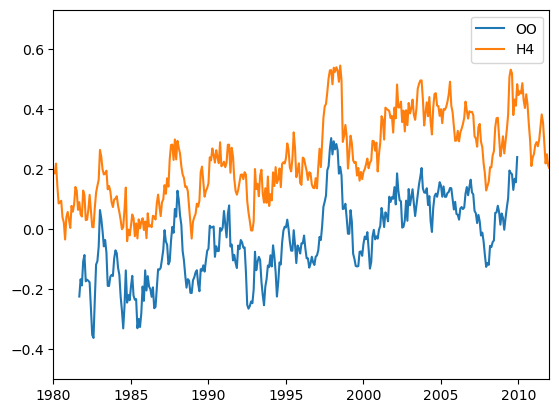

In [6]:
plt.plot(oo_time, oo_weighted_mean, label='OO')
plt.plot(h4_time, h4_weighted_mean, label='H4')
plt.legend()
plt.xlim(1980, 2012)
plt.ylim(-0.5,0.73)

Matching baselines (approximately)
==================================

The two datasets are calculated relative to very different climatology periods which you can see in the graph above. HadSST4 uses 1961-1990 (a colder period) and the new anomalies are based on the satellite period, most likely 1991-2020 (a much warmer period). There's also a seasonal cycle in the difference.

In order to get a cleaner comparison, I should use the same climatology in both cases, but that is a bit of a faff. 

At the moment, I just want to check that the two datasets are approximately similar in the overlap period and rule out any obvious reasons for the differences. The first thing we can do is just subtract from each series its average in the overlap period. That takes care of the offset between the two.

In [7]:
zeroed_h4 = h4_weighted_mean.values
zeroed_oo = oo_weighted_mean.values

selection = (oo_time[0] <= h4_time) & (h4_time <= oo_time[-1])

zeroed_h4 = h4_weighted_mean.values - np.mean(h4_weighted_mean.values[selection])

zeroed_oo = oo_weighted_mean.values - np.mean(oo_weighted_mean.values)

selection = (oo_time[0] <= h4_time) & (h4_time <= oo_time[-1])
difference = zeroed_oo - zeroed_h4[selection]

(-0.4, 0.5)

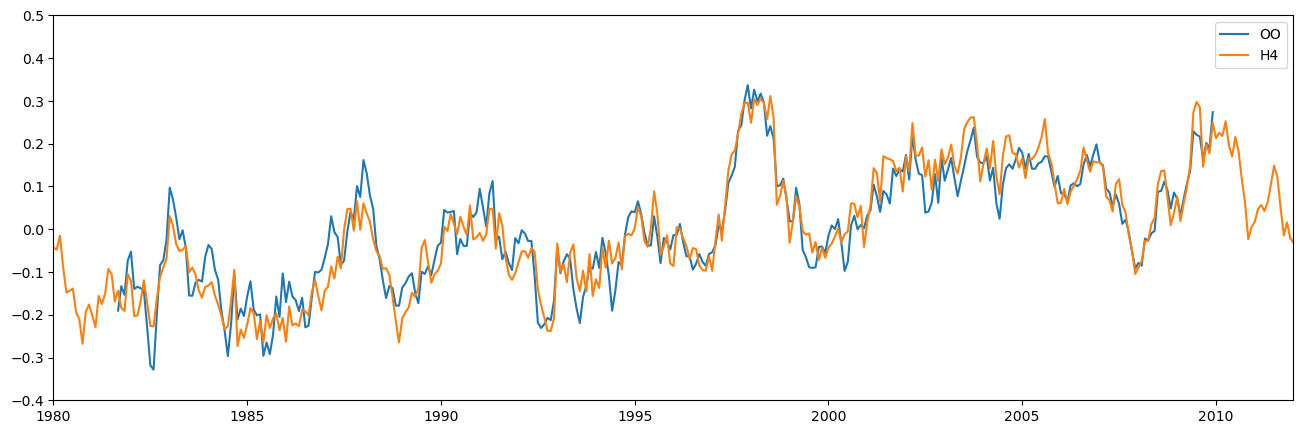

In [8]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, zeroed_oo, label='OO')
plt.plot(h4_time, zeroed_h4, label='H4')
plt.legend()
plt.xlim(1980, 2012)
plt.ylim(-0.4,0.5)

(-0.2, 0.2)

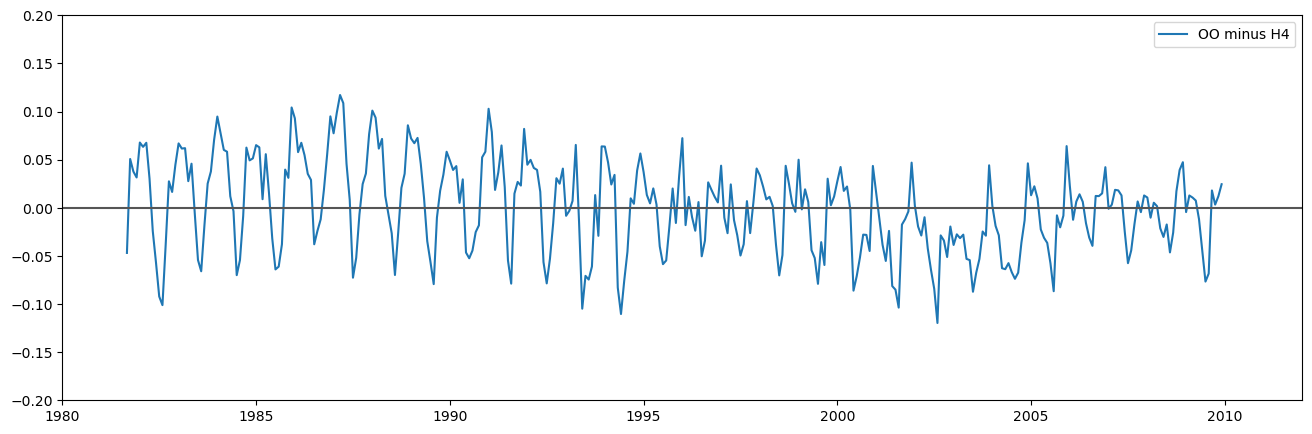

In [9]:
plt.figure()
plt.gcf().set_size_inches(16, 5)
plt.plot(oo_time, difference, label='OO minus H4')
plt.plot([1980,2012],[0,0],color='#555555')
plt.legend()
plt.xlim(1980, 2012)
plt.ylim(-0.2,0.2)

That sees a goodish match between the series already. However, the variabilities of the two series look different particularly in the early years. If we take the difference of the two then we can see there's a pronounced seasonal cycle in the difference throughout. Clearly, there's still something going on and that's likely associated with a change in the seasonality of the data. That can arise for a couple of reasons. For the time being, I think it's still largely associated with the difference between the climatologies, so lets see what happens if we remove the seasonal cycle too.

Matching baselines (less approximately)
=======================================

To remove the seasonal cycle, I separately zero the average for each month (january, february and so on) for each dataset during the overlap period - 1982-2009 in this case. That approximately removes any differences between the datasets, at least well enough to spot any major errors at this point.

In [10]:
h4_months = np.mod(np.arange(len(h4_weighted_mean)), 12)+1
oo_months = np.mod(np.arange(len(oo_weighted_mean))+8, 12)+1

zeroed_h4 = h4_weighted_mean.values
zeroed_oo = oo_weighted_mean.values

for m in range(1,13):
    selection = (oo_time[0] <= h4_time) & (h4_time <= oo_time[-1]) & (h4_months == m)
    all_months = h4_months == m

    zeroed_h4[all_months] = h4_weighted_mean.values[all_months] - np.mean(h4_weighted_mean.values[selection])

    all_months = oo_months == m
    zeroed_oo[all_months] = oo_weighted_mean.values[all_months] - np.mean(oo_weighted_mean.values[all_months])

selection = (oo_time[0] <= h4_time) & (h4_time <= oo_time[-1])
difference = zeroed_oo - zeroed_h4[selection]

(-0.4, 0.5)

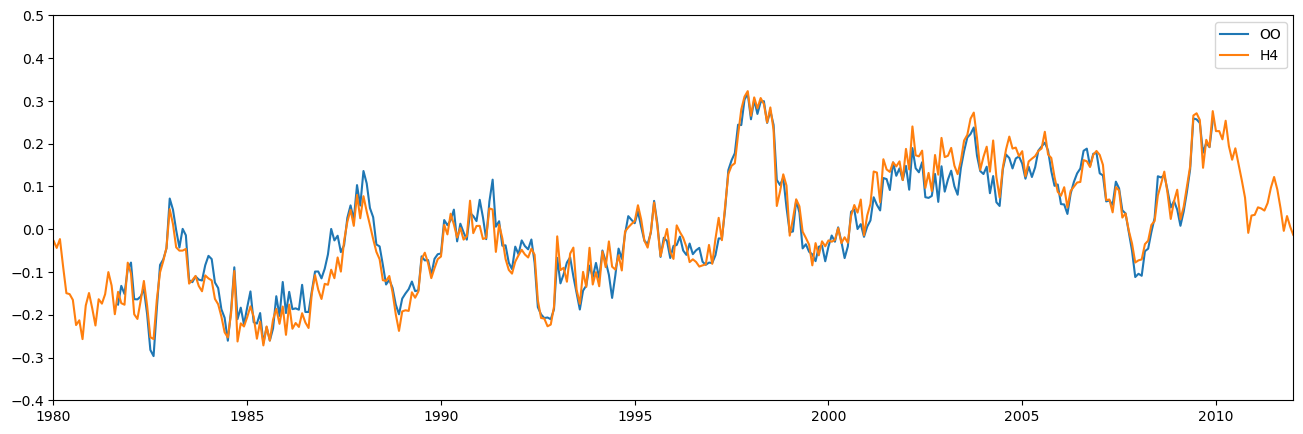

In [11]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, zeroed_oo, label='OO')
plt.plot(h4_time, zeroed_h4, label='H4')
plt.legend()
plt.xlim(1980, 2012)
plt.ylim(-0.4,0.5)

The series are in reasonably good agreement, but it's not perfect. Let's calculate the difference between the two to isolate the residual differences.

(-0.2, 0.2)

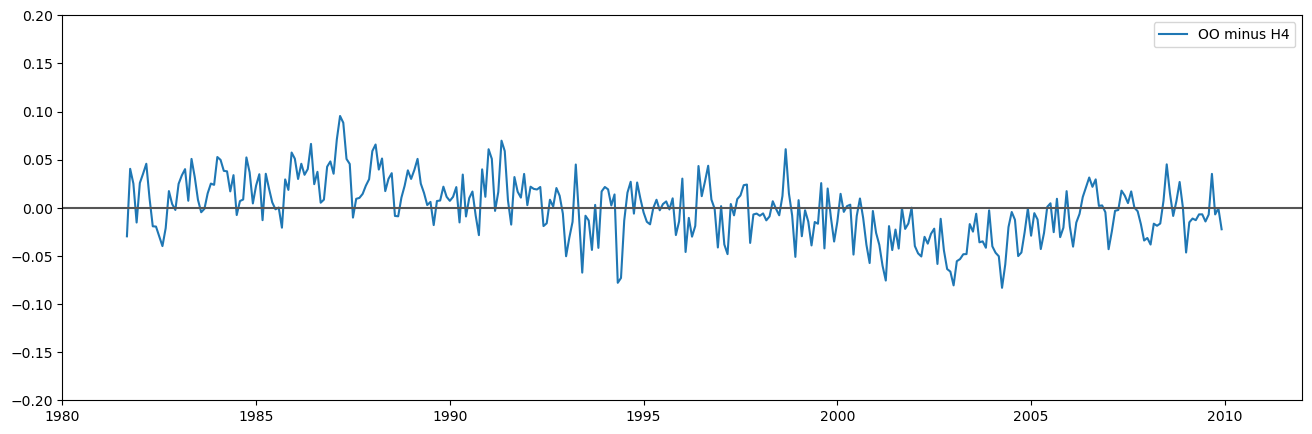

In [12]:
plt.figure()
plt.gcf().set_size_inches(16, 5)
plt.plot(oo_time, difference, label='OO minus H4')
plt.plot([1980,2012],[0,0],color='#555555')
plt.legend()
plt.xlim(1980, 2012)
plt.ylim(-0.2,0.2)

The differences are close to zero (by construction) throughout the overlap period 1982-2009. It looks like there's some low-frequency variation in the differences with the new series being warmer (relatively) at the start of the overlap and cooler around 2000-2005 and towards the end. There's also a hint of a difference in the seasonal cycles.

It's not surprising that there are differences. There are lots of differences between the QC and gridding procedures. HadSST4 uses its own QC system to process ICOADS data and the gridding is a two step process, with observations first averaged onto a medium resolution grid (1x1x5 days) and then onto a monthly grid. That changes the weight of most of the input observations. There will also be areas where HadSST4 has data in grid cells but the new analysis doesn't (due to differences in QC and climatology coverage) and vice versa.

Looking at the long-term differences, I'd guess what's happening is that the new dataset gives a substantially greater weight to buoy observations when the come on line which would tend to exacerbate the artificial cooling in the raw SST data.

However, we should also try and rule out differences in coverage as a possible cause. So, let's look at the number of cells with data in over time.

(1200.0, 1700.0)

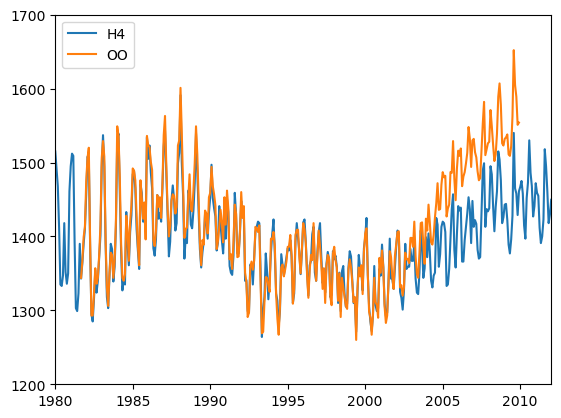

In [13]:
n_cell_h4 = np.count_nonzero(~np.isnan(hadsst4.tos.values), axis=(1,2))
n_cell_oo = np.count_nonzero(~np.isnan(oo_anomalies.sst.values), axis=(1,2))
plt.plot(h4_time, n_cell_h4, label='H4')
plt.plot(oo_time, n_cell_oo, label='OO')
plt.legend()
plt.xlim(1980, 2012)
plt.ylim(1200, 1700)

So, what I did was count non-empty grid cells in the two datasets. We can see that they track each other really well until maybe 2003. After that both see an incrase in the number of non-empty cells, but the new gridder increases faster. My initial guess here is that both datasets are seeing an influx of drifting buoy observations around that date, but IQUAM also includes Argo data so the new dataset is getting an additional bump from the ramping up of the Argo network.

Both Argo and drifting buoy observations are relatively unbiased so that would exacerbate (again) the artificial cooling in the raw data that arises from moving from a largely ship-based network c. 1981 to largely buoy (and Argo) based c. 2010 and later.